# Example of asynchronous requests (v > 1.1)
- The scope of this example is to show how to request several products together so that internal resource usage is maximized
- We extract the spectrum of the Crab in groups of 'nscw' science windows for each year from 'start_year' to 'stop_year' included
- We use a token provided by the web interface to receive dedicated emails
- We optionally show hoe to fit the spectra with a broken power law using xspec

In [1]:
#A few input parameters
osa_version="OSA10.2"
source_name="Crab"
nscw=10
start_year=2004
end_year=2006
systematic_fraction = 0.01
token=''

In [2]:
#You can provide a valid token as explained in the 'Authentication' example or skip this cell
import getpass
token = getpass.getpass('Insert the token')

Insert the token········


In [3]:
#We hardcode a catalog for the Crab
api_cat={
    "cat_frame": "fk5", 
    "cat_coord_units": "deg", 
    "cat_column_list": [
        [0, 7], 
        ["1A 0535+262", "Crab"], 
        [125.4826889038086, 1358.7255859375], 
        [84.72280883789062, 83.63166809082031], 
        [26.312734603881836, 22.016284942626953], 
        [-32768, -32768], 
        [2, 2], 
        [0, 0], 
        [0.0002800000074785203, 0.0002800000074785203]], 
    "cat_column_names": [
        "meta_ID", 
        "src_names", 
        "significance", 
        "ra", 
        "dec", 
        "NEW_SOURCE", 
        "ISGRI_FLAG", 
        "FLAG", 
        "ERR_RAD"
    ], 
    "cat_column_descr": 
        [
            ["meta_ID", "<i8"], 
            ["src_names", "<U11"], 
            ["significance", "<f8"], 
            ["ra", "<f8"], 
            ["dec", "<f8"], 
            ["NEW_SOURCE", "<i8"], 
            ["ISGRI_FLAG", "<i8"], 
            ["FLAG", "<i8"], 
            ["ERR_RAD", "<f8"]
        ], 
    "cat_lat_name": "dec", 
    "cat_lon_name": "ra"
}



## Let's get some logging

This is to help visualizing the progress.

* WANRING is the default level
* INFO writes some more information
* DEBUG is maily for developers and issue tracking

In [4]:
import logging
#default
#logging.getLogger().setLevel(logging.WARNING)
#slightly more verbose
logging.getLogger().setLevel(logging.INFO)
#all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler()) 

In [5]:
#Different instances of the platform, the first two are available only internally
import numpy as np
import json
import oda_api.api

import oda_api

from pkg_resources import parse_version

assert parse_version(oda_api.__version__) > parse_version("1.1.0")


def dispatcher(_oda_platform='production'):
    disp = oda_api.api.DispatcherAPI(
        url = {
            'staging' : 'http://dispatcher.staging.internal.odahub.io',
            'production': 'https://www.astro.unige.ch/mmoda/dispatch-data',
        }[_oda_platform]
    )
    disp.get_instrument_description("isgri")
    return disp

disp = dispatcher('production')


--------------
query_name: src_query
 name: src_name,  value: test,  units: str, 
 name: RA,  value: 0.0,  units: deg, 
 name: DEC,  value: 0.0,  units: deg, 
 name: T1,  value: 2001-12-11T00:00:00.000,  units: None, 
 name: T2,  value: 2001-12-11T00:00:00.000,  units: None, 
 name: token,  value: None,  units: str, 

--------------
query_name: isgri_parameters
 name: user_catalog,  value: None,  units: str, 
 name: scw_list,  value: [],  units: names_list, 
 name: selected_catalog,  value: None,  units: str, 
 name: radius,  value: 5.0,  units: deg, 
 name: max_pointings,  value: 50,  units: None, 
 name: osa_version,  value: None,  units: str, 
 name: integral_data_rights,  value: public,  units: str, 
 name: E1_keV,  value: 15.0,  units: keV, 
 name: E2_keV,  value: 40.0,  units: keV, 

--------------
query_name: isgri_image_query
 product_name: isgri_image
 name: detection_threshold,  value: 0.0,  units: sigma, 
 name: image_scale_min,  value: None,  units: None, 
 name: image_sca

- Here, we collect and spectra for each year in a random sample of nscw=10 science windows
- We use the hard-coded catalog.

In [7]:
spectrum_results=[]

disp_by_ys = {}
data_by_ys = {}

par_dict = {"RA": "83.63166809082031",
            "DEC": "22.016284942626953",
            "radius": "10",
            'instrument':'isgri',
          'product': 'isgri_spectrum',
          'osa_version' : osa_version,
          'product_type': 'Real',
            'max_pointings': nscw,
          'selected_catalog' : json.dumps(api_cat)}

# Should you need to access private data, just add this option
#,"integral_data_rights": "all-private"}

if token != '':
    par_dict.update({'token': token})

while True:
    spectrum_results=[]

    for year in range(start_year, end_year+1): 
        T1_utc='%4d-01-01T00:00:00.0'%year
        T2_utc='%4d-12-31T23:59:59.0'%year # there are 30 days in June!
        
        print(T1_utc,'-',T2_utc)

        par_dict.update({'T1': T1_utc,
                        'T2': T2_utc})
        
        if year >= 2016:
            osa_version='OSA11.1'
        else:
            osa_version='OSA10.2'

        #Just renaiming for a general dictionary key
        ys = year

        # We start one dipatcher for each job,
        # they will run in parallel until products are ready
        if ys not in disp_by_ys:
            disp_by_ys[ys] = oda_api.api.DispatcherAPI(url=disp.url, wait=False) #Note the flag wait=False

        _disp = disp_by_ys[ys]

        data = data_by_ys.get(ys, None)

        if data is None and not _disp.is_failed:
            
            #We submit or we poll 
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            # We retrieve data
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                data_by_ys[ys] = data                

        spectrum_results.append(data)
        
    n_complete = len([ year for year, _disp in disp_by_ys.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_ys)}")
    if n_complete == len(disp_by_ys):
        print("done!")
        break
    print("not done")


2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


- waiting for remote response (since 2021-08-25 15:21:14), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13

... query status prepared => submitted
... assigned job id: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 14 seconds (14/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
non-waiting dispatcher: terminating

query not complete, please poll again later


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


- waiting for remote response (since 2021-08-25 15:21:31), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254

... query status prepared => submitted
... assigned job id: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating

query not complete, please poll again later


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0


- waiting for remote response (since 2021-08-25 15:21:45), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: PWBXKFZ2CDLNY6MO job: 326b0028284c8201

... query status prepared => done
... assigned job id: 326b0028284c8201
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating


Is complete  True


- waiting for remote response (since 2021-08-25 15:22:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: PWBXKFZ2CDLNY6MO job: 326b0028284c8201

... query status prepared => done
... assigned job id: 326b0028284c8201
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating
- waiting for remote response (since 2021-08-25 15:22:59), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 115 seconds (13/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:23:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 110 seconds (12/12); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:23:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 138 seconds (12/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:23:33), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 132 seconds (12/12); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:23:44), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 162 seconds (12/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:23:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 159 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:24:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 187 seconds (12/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:24:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 181 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:24:33), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 208 seconds (12/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:24:43), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 203 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:24:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 230 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:25:05), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 224 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:25:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 252 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:25:27), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 246 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:25:38), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 274 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:25:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 268 seconds (12/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:26:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 295 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:26:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 289 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:26:21), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 317 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:26:32), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 311 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:26:43), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 339 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:26:54), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 332 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:27:04), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 360 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:27:15), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 354 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:27:26), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 381 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:27:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 374 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:27:46), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 402 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:27:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 396 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:28:08), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 424 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:28:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 418 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:28:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 49 messages since 447 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ii_spectra_extract : main done : 023900270010.001
- waiting for remote response (since 2021-08-25 15:28:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 441 seconds (11/14); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:28:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 468 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:29:03), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 467 seconds (11/15); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:29:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 496 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:29:31), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 494 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:29:46), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 523 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:29:58), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 518 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:30:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 546 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:30:21), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 539 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:30:31), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 567 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:30:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 561 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:30:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 589 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:04), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 582 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:14), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 610 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:24), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 604 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 631 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:46), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 624 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:31:56), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 653 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:32:08), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 647 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:32:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 676 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:32:31), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 670 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:32:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 698 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:32:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 693 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:05), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 721 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 715 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:27), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 743 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:38), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 736 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 764 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:33:59), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 759 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:34:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 787 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:34:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 780 seconds (11/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:34:32), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 807 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:34:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 814 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:35:06), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 842 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:35:17), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 836 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:35:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 863 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:35:38), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 857 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:35:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 885 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:36:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 883 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:36:15), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 911 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:36:26), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 905 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:36:37), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 933 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:36:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 927 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:36:59), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 955 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:37:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 949 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:37:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 978 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:37:32), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 971 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:37:43), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 999 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:37:54), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 993 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:38:05), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1021 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:38:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1015 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:38:27), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1044 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:38:38), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1038 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:38:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1065 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1059 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1087 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1081 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:33), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1108 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:43), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1101 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:39:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1130 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:40:05), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1124 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:40:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1152 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:40:27), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1146 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:40:38), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 | the job is working remotely, please wait status=submitted job_id=9b1997c7 in 51 messages since 1174 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:40:49), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1168 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:41:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 / the job is working remotely, please wait status=submitted job_id=9b1997c7 in 52 messages since 1196 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:41:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1190 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:41:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 - the job is working remotely, please wait status=submitted job_id=9b1997c7 in 52 messages since 1218 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:41:33), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1212 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:41:44), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13
 \ the job is working remotely, please wait status=submitted job_id=9b1997c7 in 52 messages since 1240 seconds (11/14); in 4 SCW so far; nodes (6): 5 computed 0 restored
... ISGRISpectraSum : treating dependencies : inapplicable
- waiting for remote response (since 2021-08-25 15:41:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1235 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:42:07), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 1 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0


session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13

... query status submitted => done
query COMPLETED SUCCESSFULLY (state done)


Is complete  True


- waiting for remote response (since 2021-08-25 15:42:37), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: ARMSNPTWYJVFH4XZ job: 9b1997c75d18cd13

... query status prepared => done
... assigned job id: 9b1997c75d18cd13
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating
- waiting for remote response (since 2021-08-25 15:43:05), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1304 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:43:16), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 / the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1315 seconds (12/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:43:27), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 - the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1326 seconds (11/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:43:37), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 \ the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1336 seconds (11/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:43:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254
 | the job is working remotely, please wait status=submitted job_id=d4f1bacb in 1 messages since 1348 seconds (11/24); in 0 SCW so far; nodes (1): 0 computed 0 restored
... ISGRISpectraSum : main starting : inapplicable
- waiting for remote response (since 2021-08-25 15:44:00), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis


Is complete  False
2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 2 / 3
not done
2004-01-01T00:00:00.0 - 2004-12-31T23:59:59.0
2005-01-01T00:00:00.0 - 2005-12-31T23:59:59.0


session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254

... query status submitted => done
query COMPLETED SUCCESSFULLY (state done)


Is complete  True


- waiting for remote response (since 2021-08-25 15:44:37), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 8VO1XT5P6XI695E4 job: d4f1bacbc3f1c254

... query status prepared => done
... assigned job id: d4f1bacbc3f1c254
query COMPLETED SUCCESSFULLY (state done)
non-waiting dispatcher: terminating


2006-01-01T00:00:00.0 - 2006-12-31T23:59:59.0
complete 3 / 3
done!


- This part saves the spectra in fits files and updates some keywords

In [13]:
from astropy.io import fits
# This part saves the spectra in fits files and updates some keywords
for year, data in data_by_ys.items():
    print(year)
    for ID,s in enumerate(data._p_list):
        if (s.meta_data['src_name']==source_name):
            if(s.meta_data['product']=='isgri_spectrum'):
                ID_spec=ID
            if(s.meta_data['product']=='isgri_arf'):
                ID_arf=ID
            if(s.meta_data['product']=='isgri_rmf'):
                ID_rmf=ID

    print(ID_spec, ID_arf, ID_rmf)

    spec=data._p_list[ID_spec].data_unit[1].data
    arf=data._p_list[ID_arf].data_unit[1].data
    rmf=data._p_list[ID_rmf].data_unit[2].data
    expos=data._p_list[0].data_unit[1].header['EXPOSURE']
    name=source_name+'_'+str(year)
    specname=name+'_spectrum.fits'
    arfname=name+'_arf.fits.gz'
    rmfname=name+'_rmf.fits.gz'
    data._p_list[ID_spec].write_fits_file(specname)
    data._p_list[ID_arf].write_fits_file(arfname)
    data._p_list[ID_rmf].write_fits_file(rmfname)
    hdul = fits.open(specname, mode='update')
    hdul[1].header.set('EXPOSURE', expos)
    hdul[1].header['RESPFILE']=rmfname
    hdul[1].header['ANCRFILE']=arfname
    hdul[1].data['SYS_ERR']=systematic_fraction

    hdul.close()

2006
3 4 5
2004
3 4 5
2005
3 4 5


## If xspec is available, we make a fit of each spectrum

No such file: .pha
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
 Model systematic error set to 0

Model cflux<1>*bknpower<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   5    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   6    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   7    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


1 spectrum  in use
 
Spectral Data File: Crab_2004_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -nan7
ISGRI ignore: **-20.00,500.-**

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.
PGPLOT /png: writing new file as pgplot.png_2


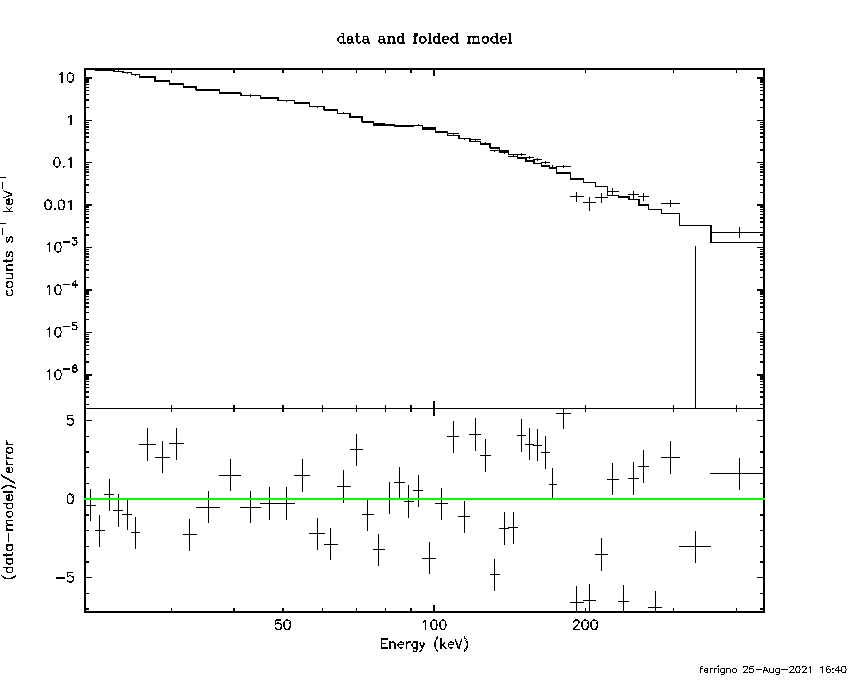

Lvl    3:lg10Flux    4:PhoIndx1    6:PhoIndx2
468.981      0.0156561     2      -7.84092       2.05306       2.20612
 Variances and Principal Axes
                 3        4        6  
 1.0606E-06|  0.9996  -0.0256  -0.0088  
 2.2275E-05| -0.0261  -0.9975  -0.0652  
 1.1710E-03|  0.0071  -0.0654   0.9978  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.134e-06   1.161e-08   8.294e-06
   1.161e-08   2.718e-05  -7.502e-05
   8.294e-06  -7.502e-05   1.166e-03
------------------------------------

Model cflux<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      20.0000      frozen
   2    1   cflux      Emax       keV      80.0000      frozen
   3    1   cflux      lg10Flux   cgs      -7.84092     +/-  1.06475E-03  
   4    2   bknpower   PhoIndx1            2.05306      +/-  5.21349E-03  
   5    2   bknpower   BreakE     keV      100.000    

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.
PGPLOT /png: writing new file as pgplot.png_2


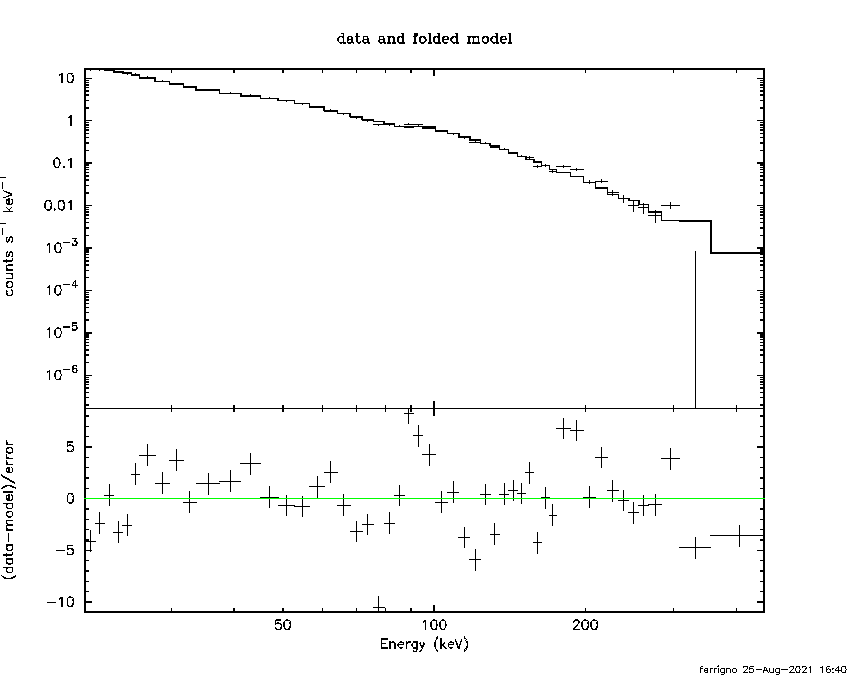

  15295.9      -4      -7.81860       2.19399       2.30009
609.459      699.845      -5      -7.82089       2.18721       2.30344
609.459      6.35908      -6      -7.82091       2.18722       2.30342
 Variances and Principal Axes
                 3        4        6  
 9.3715E-07|  0.9980  -0.0615  -0.0122  
 1.8196E-05| -0.0622  -0.9950  -0.0780  
 7.9412E-04|  0.0073  -0.0786   0.9969  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.046e-06   6.133e-07   5.859e-06
   6.133e-07   2.292e-05  -6.079e-05
   5.859e-06  -6.079e-05   7.893e-04
------------------------------------

Model cflux<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      20.0000      frozen
   2    1   cflux      Emax       keV      80.0000      frozen
   3    1   cflux      lg10Flux   cgs      -7.82091     +/-  1.02288E-03  
   4    2   bknpower   PhoIndx1            2

   3    1   cflux      lg10Flux   cgs      -7.83062     +/-  1.15363E-03  
   4    2   bknpower   PhoIndx1            2.02688      +/-  5.81095E-03  
   5    2   bknpower   BreakE     keV      100.000      frozen
   6    2   bknpower   PhoIndx2            2.16951      +/-  4.02796E-02  
   7    2   bknpower   norm                1.00000      frozen
________________________________________________________________________


Fit statistic  : Chi-Squared                  420.68     using 52 bins.

Test statistic : Chi-Squared                  420.68     using 52 bins.
 Null hypothesis probability of 1.55e-60 with 49 degrees of freedom
*** Parameter 1 is not a variable model parameter and no confidence range will be calculated.
*** Parameter 2 is not a variable model parameter and no confidence range will be calculated.
*** Parameter 5 is not a variable model parameter and no confidence range will be calculated.
*** Parameter 7 is not a variable model parameter and no confidence range will 

***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.
PGPLOT /png: writing new file as pgplot.png_2


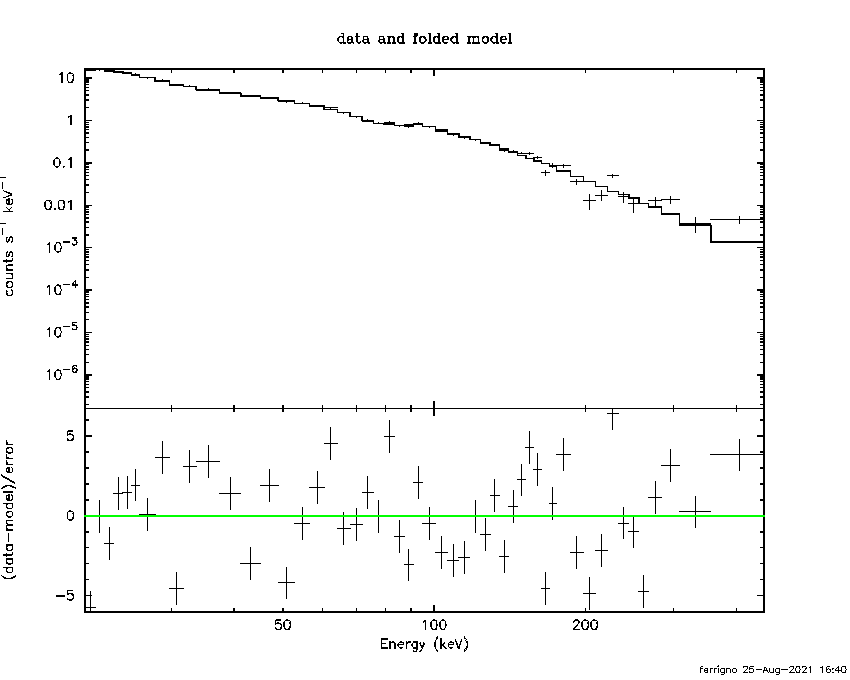

 -7.82946    (-0.00116403,0.00115807)
     4      2.02109      2.03269    (-0.00579708,0.00580121)
     6      2.12898      2.21074    (-0.0405342,0.0412269)


In [14]:
try:

    import xspec
    import shutil
    from IPython.display import Image
    from IPython.display import display 

    xspec.Fit.statMethod = "chi"

    #init dictionaries
    fit_by_lt={}

    model='cflux*bknpow'

    xspec.AllModels.systematic=0.0
    low_energies=[20]
    freeze_pow_ebreak=1

    for year in range(start_year,end_year+1):

        for c_emin in low_energies: #np.linspace(17,40,5):    
            xspec.AllData.clear()

            m1=xspec.Model(model)

            specname=source_name+'_'+str(year)+'_spectrum.fits'

            xspec.AllData(specname)

            s = xspec.AllData(1)

            isgri = xspec.AllModels(1)

            print(m1.nParameters)

            xspec.AllData.ignore('bad')
            xspec.AllData.ignore('500.0-**')

            ig="**-%.2f,500.-**"%c_emin
            print("ISGRI ignore: "+ ig)
            s.ignore(ig)

            #Key for output
            lt_key='%d_%.10lg'%(year, c_emin)

            isgri.cflux.lg10Flux=-8            

            isgri.cflux.Emin=20.
            isgri.cflux.Emax=80.

            isgri.bknpower.norm = "1,-1"
            isgri.bknpower.PhoIndx1 = "2.0,.01,1.,1.,3.,3."
            isgri.bknpower.PhoIndx2 = "2.2,.01,1.,1.,3.,3."
            isgri.bknpower.BreakE = "100,-1,20,20,300,300"

            xspec.Fit.perform()
            isgri.bknpower.BreakE.frozen = freeze_pow_ebreak  > 0

            xspec.Fit.perform()

            max_chi=np.ceil(xspec.Fit.statistic / xspec.Fit.dof)

            xspec.Fit.error("1.0 max %.1f 1-%d"%(max_chi,m1.nParameters))


            fit_by_lt[lt_key]=dict(
                    emin=c_emin,
                    year=year,
                    chi2_red=xspec.Fit.statistic/xspec.Fit.dof,                                
                    chi2=xspec.Fit.statistic,
                    ndof=xspec.Fit.dof,                                    
                )

            for i in range(1,m1.nParameters+1): 
                if (not isgri(i).frozen) and (not bool(isgri(i).link)):
                    #use the name plus position because there could be parameters with same name from multiple 
                    #model components (e.g., several gaussians)
                    print(isgri(i).name, "%.2f"%(isgri(i).values[0]), isgri(i).frozen,bool(isgri(i).link) )
                    fit_by_lt[lt_key][isgri(i).name+"_%02d"%(i)]=[ isgri(i).values[0], isgri(i).error[0], isgri(i).error[1] ]



            xspec.Plot.device="/png"
            #xspec.Plot.addCommand("setplot en")
            xspec.Plot.xAxis="keV"
            xspec.Plot("ldata del")
            xspec.Plot.device="/png"

            fn="fit_%s.png"%lt_key
            fit_by_lt[lt_key]['plot_fname'] = fn

            shutil.move("pgplot.png_2", fn)

            _=display(Image(filename=fn,format="png"))

except ImportError:
    print("no problem!")